In [39]:
import torch
from torch import nn
from torch.nn import functional as F
import math

## Building the base model of transfomers (the "Attention is all you need" paper consider of a base model and a large model)

### Dropout_prob of 0.1 is mentioned in the paper for the base model

### NOTE: Dropout is for each sub_layer(to the ouput of that sub_layer before it is added with the sub_layer input and normalized), sums of embeddings and the positional encodings

# Embedding layer


In [40]:
#Embeddings are token representations. They are like parameters which will be learned.
class Embedding_Layer(nn.Module):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.d_model=d_model
        self.vocab.size=vocab_size
        self.embeddings=nn.Embedding(self.vocab_size,self.d_model) #Stores all the embeddings
        
    def forward(self,x):
        unscaled_emb=self.embeddings(x)
        scaled_embedding=torch.sqrt(unscaled_emb) #to scale them
        return scaled_embedding
        

# Position encoding layer



## There are 2 methods:
### a) Position Embedding
### b) Position encoding

## Using the 2nd one with the following formula as mentioned in "Attention is all you need" paper.
## ADV -> can handle positions which are unseen during the training 

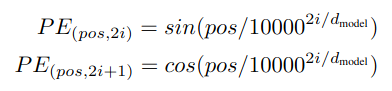

<div>
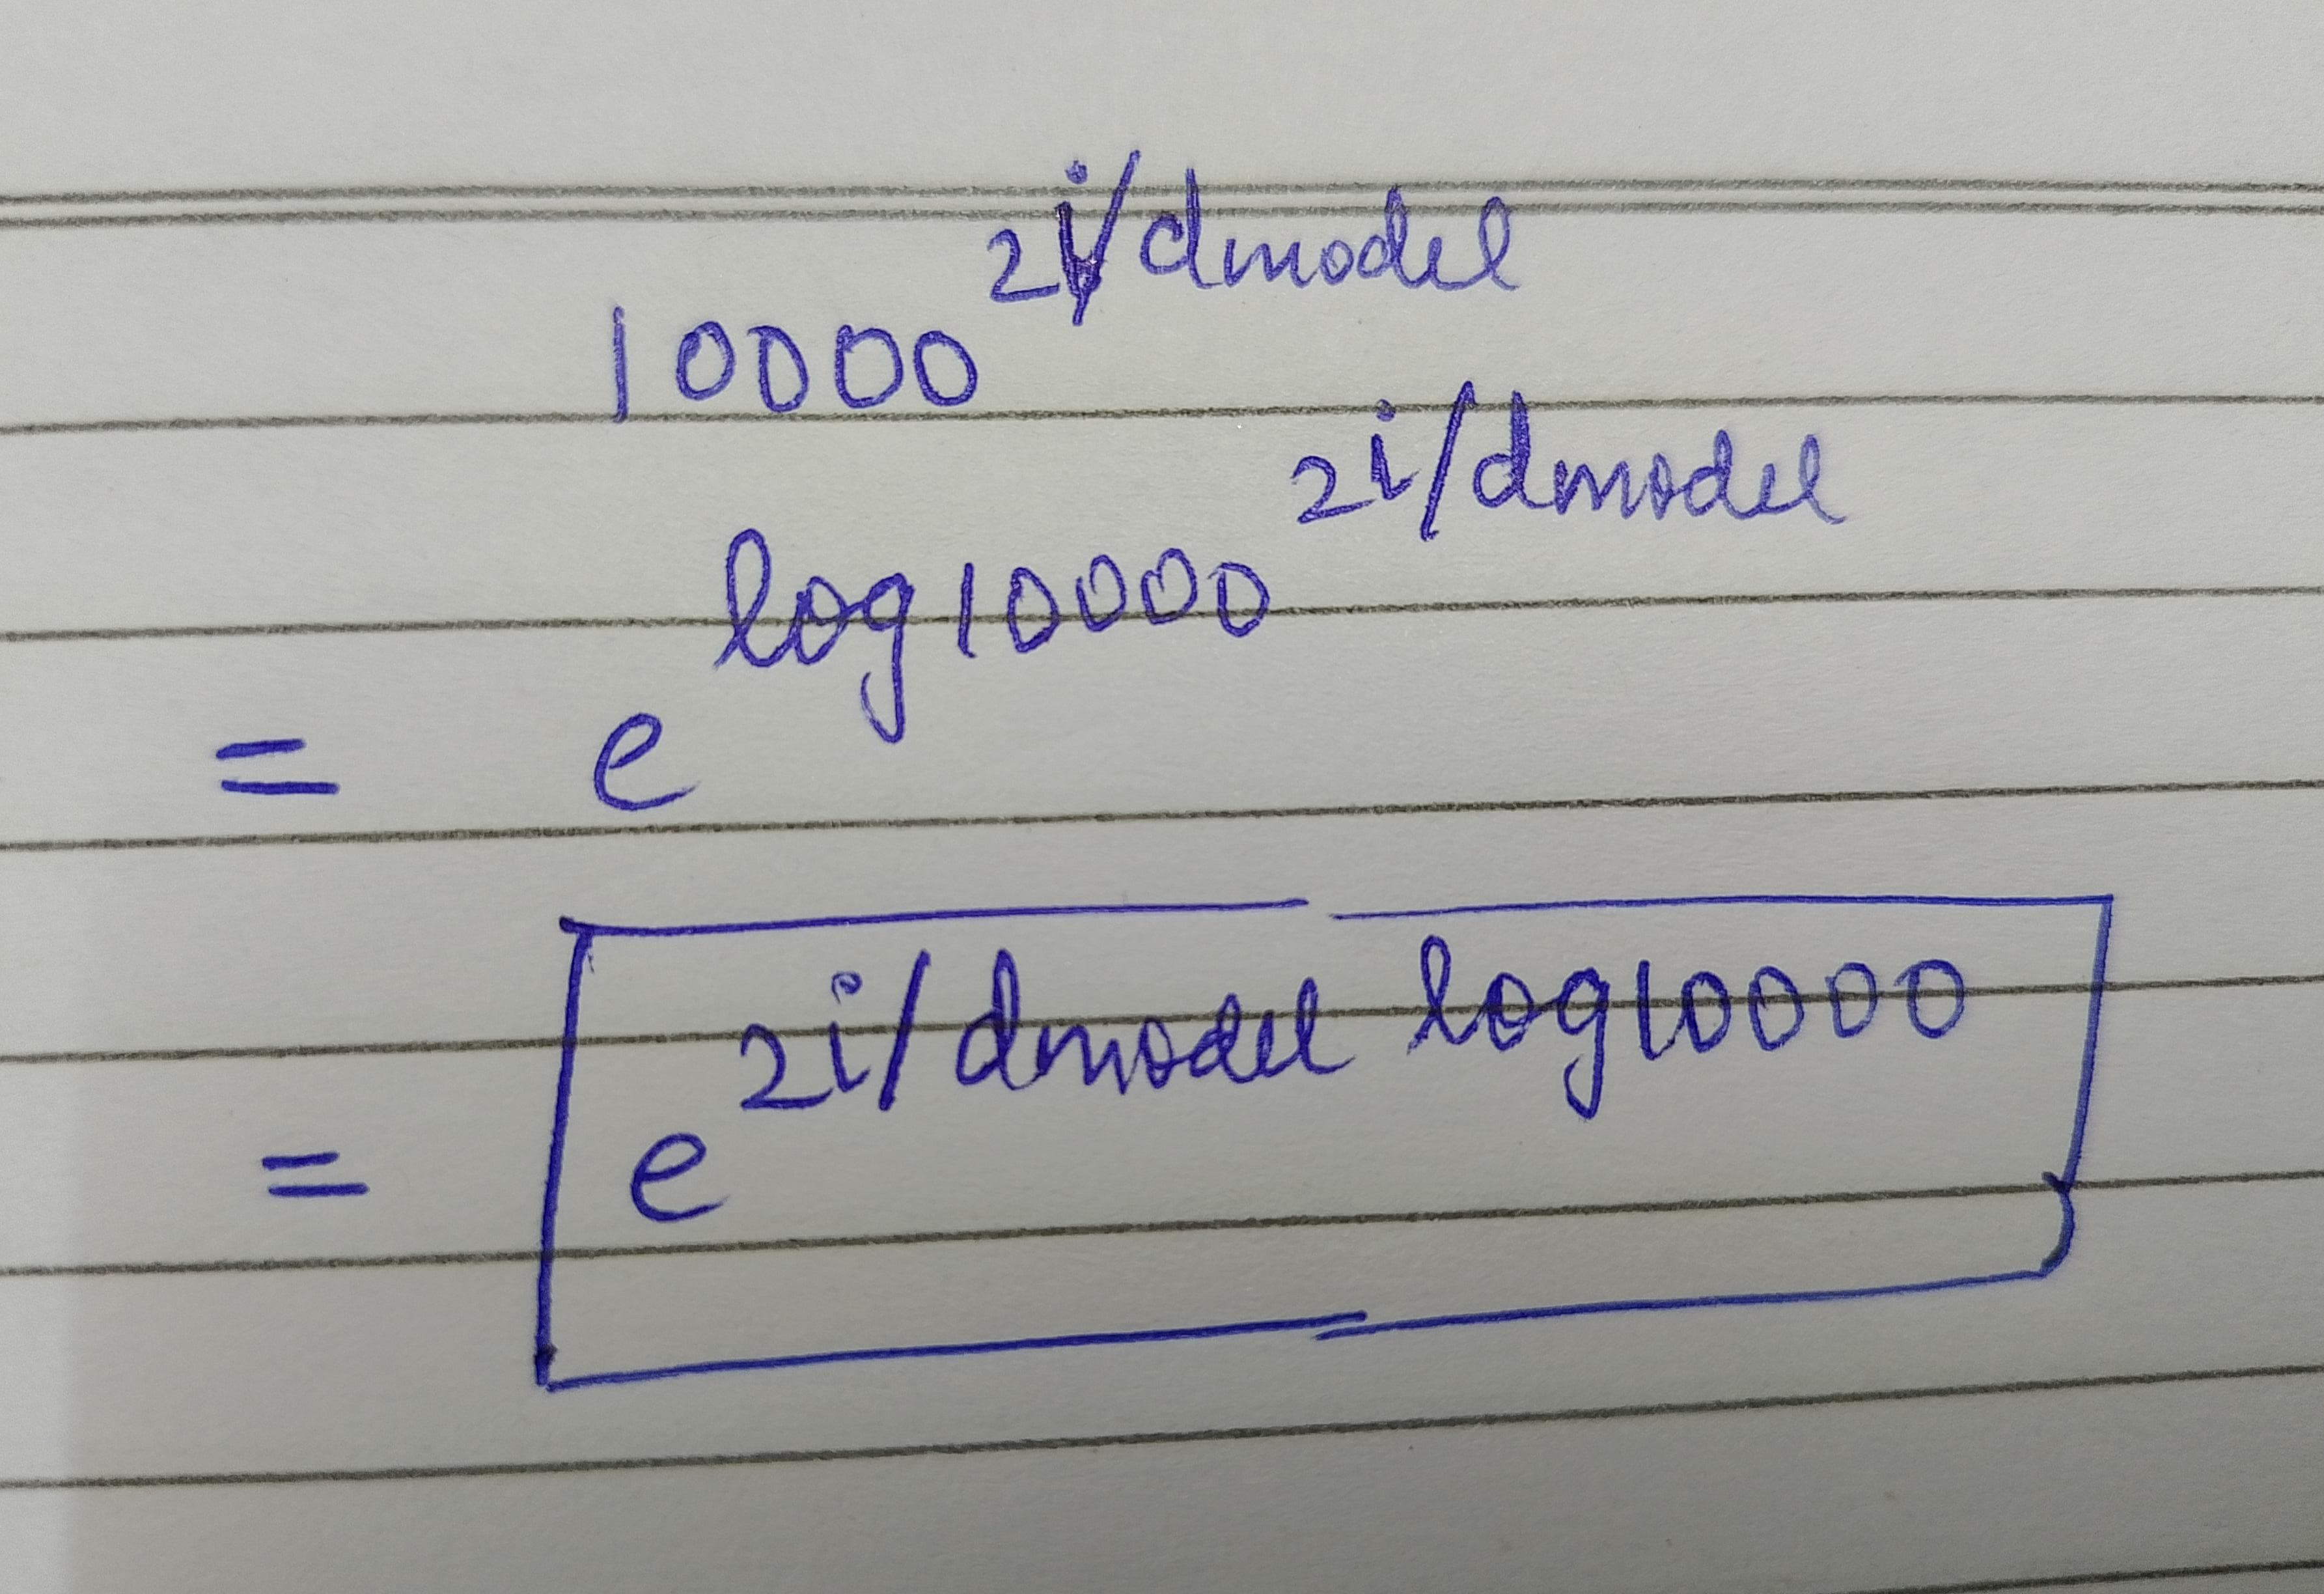
</div>

In [41]:
#Encoding for 1000 words
class Position_Encoding_Layer(nn.Module):
    def __init__(self,d_model,dropout_prob=0.1,max_len=5000):
        super().__init__()
        self.d_model=d_model
        self.max_len=max_len
        self.dropout=nn.Dropout(dropout_prob)#regularization technique
        #making position encoding table in which each row is the position number and the vector in each row is the
        #encoded vector for that table
        PE=torch.zeros(max_len,self.d_model)
        
        #NOTE: We can either use for loop OR take advantage of matrix multiplication
        
        #MM!
        #At each position, the resultant vector is by multiplication with the position itself
        #Thus, creating a position  vector which will get broadcasted accordingly on multiplication 
        
        position=torch.arange(max_len).reshape(max_len,1)
        
        #Making divsion term vector which is of size d_model/2 as each element will contribute in two elements of
        #encoded vector
        
        #As the base in torch in torch.exp cannot be changed the expression is arranged as such that the entire 
        #thing is raised as the power of e.
        division=torch.exp(torch.arange(max_len,2,dtype=float)*(math.log(10000)/self.d_model))
    
    
        #sin terms at even indices and cos terms at odd indices
        PE[:,:self.d_model:2]=torch.sin(position/division)
        PE[:,:self.d_model:2]=torch.cos(position/division)
        
        self.register_buffer('PE',PE)
        #WHY?
        #Ans-> If you have parameters in your model, which should be saved and restored in the state_dict, but 
        #not trained by the optimizer, you should register them as buffers.
        
    def forward(self,x):
        ans=x+self.PE[:,:x.shape[1]].required_grad_(False)
        result=self.dropout(ans)
        return result

# Multi-Head Attention Layer


In [42]:
#Adding additional scaling, masking and dropout to my already built code of multi-head attention


#NOTE: Parameters of the neurons are always multiplied with the elements of the last dimension 
#SAY, x is (batch,len,features); so on passing through nn.Linear features will get linearly transformed
class Multi_Head_Attention(nn.Module):
    def __init__(self,d_model,dropout_prob=0.1,heads=4):
        super().__init__()
        self.d_model=d_model
        self.dropout=nn.Dropout(dropout_prob)
        
        assert self.d_model % heads == 0
        self.heads=heads
        self.s=d_model//heads
        
        self.toqueries=nn.Linear(self.d_model,self,d_model,bias=False)
        self.tokeys=nn.Linear(self.d_model,self,d_model,bias=False)
        self.tovalues=nn.Linear(self.d_model,self,d_model,bias=False)
        self.tooutput=nn.Linear(self.d_model,self,d_model,bias=False) #additonal scaling
    def forward(self,x,encoded_ouput=None,mask=None):
        #always ignoring the batch dimension of input(for easy understanding)
        seq_len,_=x.shape
        
        Q=self.toqueries(x)
        
        if encoded_ouput is None:
            K=self.tokeys(x)
            V=self.values(x)            
        else:
            K=self.tokeys(encoded_ouput)
            V=self.tovalues(encoded_ouput)
            
            
        #breaking them into batches for easy batch multiplication
        queries=Q.reshape(seq_len,self.s,self.heads).transpose(1,2).transpose(0,1)
        keys=K.reshape(seq_len,self.s,self.heads).transpose(1,2).transpose(0,1)
        values=V.reshape(seq_len,self.s,self.heads).transpose(1,2).transpose(0,1)
        
        raw_weights=torch.bmm(queries,keys.transpose())/(self.s ** (1/2))
        
        #MASKING
        if mask is not None:
            raw_weights=raw_weights.masked_fill_(mask == 0, -1e9)
        
        
        weights=F.softmax(raw_weights,dim=2)
        
        #DROPOUT
        weights=self.dropout(weights)
        
        
        
        init_result=torch.bmm(weights,values)
        
        init_result=result.transpose(0,1).reshape(seq_len,self.heads*self.s)
        
        #making additional scaling
        result=self.tooutput(init_result)
        
        return result
        

# Normalization Layer

### NOTE: Normalization is a common technique in DL used to the normalize the values for stable learning and convergence of the gradients.

In [43]:
#Also adding scaling and shifting of values after normalization, for the model to be more adaptable and flexible,
#and be able to amplify those values values in whichever way it wants to.

#final value=alpha*X + gamma
#Alpha -> scaling
#Gamma -> shifting

class Normalization_Layer(nn.Module):
    def __init__(self,d_model,eps=1e-6):
        super().__init__()
        self.d_model=d_model
        self.eps=eps
        #initially we want to start with no scaling and shifting
        #no scaling -> all elements are 1s
        #no shifting -> all elements are 0s
        self.alpha=nn.Parameters(torch.ones(1,self.d_model))
        self.gamma=nn.Parameters(torch.zeros(1,self.d_model))
        
    def forward(self,x):
        mean=x.mean(dim=1,keepdim=True)
        variance=x.var(dim=1,keepdim=True)
        #tensors of size (seq_len,1)
        
        normalized=x-mean/(torch.sqrt(variance)+self.eps)
        
        result=normalized*self.alpha + self.gamma
        
        return result

# Feed-Forward Layer

In [44]:
class Feed_Forward_Layer(nn.Module):
    def __init__(self,d_model,dropout_prob=0.1,dff=2048):
        super().__init__()
        self.d_model=d_model
        self.dff=dff
        self.linear1=nn.Linear(self.d_model,self.dff)
        self.ReLU=nn.ReLU()
        self.dropout=nn.Dropout(dropout_prob)
        self.linear2=nn.Linear(self.dff,self.d_model)
        
    def forward(self,x):
        result=self.linear2(self.dropout(self.ReLU(self.linear1(x))))
        
        return result

# Residual Connections Layer

### Residual connections (a.k.a. Skip connections) are used to skip sub-layers make the gradients flow smoothly through the entire architecture thereby preventing the problem of vanishing gradients and helping in the training of neural networks

### Here, the input is directly normalized and added to the output. 

### Intuitively, as the output contains both the input and self-attented input, if the gradients have a problem in flowing through the self-attented input, they can easily flow through the input.|

In [45]:
#defining separate class for Residual connections
class Residual_Connections_Layer(nn.Module):
    def __init__(self,d_model,eps=1e-6):
        super().__init__()
        self.d_model=d_model
        self.eps=eps
        self.normalize=Normalization_Layer(self.d_model,eps)
    
    def forward(self,x,attented_output):
        result=self.normalize(x+attented_output)
        return result
        

# Till now we have defined all the building blocks of an encoder and decoder.

# Now we will define the encoder and decoder which will act as the building blocks of the transformers 

In [46]:
class Encoder(nn.Module):
    def __init__(self,d_model,max_len,vocab_size,dff,dropout_prob=0.1,eps=1e-6,heads=4):
        super().__init__()
        #sub-layer1
        self.attention=Multi_Head_Attention(d_model,dropout_prob,heads)
        self.residual_connection1=Residual_Connections_Layer(d_model,eps)
        #sub-layer2
        self.ff=Feed_Forward_Layer(d_model,dropout_prob,dff)
        self.residual_connection2=Residual_Connections_Layer(d_model,eps)
        
    def forward(self,x):
        sub_layer1=self.residual_connection1(x,self.attention(x))
        sub_layer2=self.residual_connection2(sub_layer1,self.ff(sublayer1))
        result=sub_layer2
        
        return result
        
        
        

In [47]:
class Decoder(nn.Module):
    def __init__(self,d_model,max_len,vocab_size,dff,dropout_prob=0.1,eps=1e-6,heads=4):
        super().__init__()
        #sub-layer1
        self.masked_attention=Multi_Head_Attention(d_model,dropout,heads)
        self.residual_connection1=Residual_Connections_Layer(d_model,eps)
        #sub-layer2
        self.cross_attention=Multi_Head_Attention(d_model,dropout,heads)
        self.residual_connection2=Residual_Connections_Layer(d_model,eps)
        #sub-layer3
        self.ff=Feed_Forward_Layer(d_model,dropout_prob,dff)
        self.residual_connection3=Residual_Connections_Layer(d_model,eps)
        
    def forward(self,x,mask,encoded_output,source_mask):
        sub_layer1=self.residual_connection1(x,self.masked_attention(x,mask))
        sub_layer2=self.residual_connection2(sub_layer1,self.cross_attention(sub_layer1,encoded_ouput,source_mask))
        #Here, a source_mask is needed. WHY? 
        #For the cross-attention to work properly,the seq_len of encoded_ouput(input through encoder) and output
        #have to be the same, so they are made 0 and a mask(padding mask) is added for it.
        sub_layer3=self.residual_connection3(sub_layer2,self.ff(sublayer2))
        
        result=sub_layer3
        
        return result
        

# Now, assembling the encoder and decoder components into the transformers module as a whole.

# Need of masking

The original transformers model is an auto-regressive model i.e. it always predicts the next token which is considered for the token after that (OR predicts tokens one by one).

𝘋𝘶𝘳𝘪𝘯𝘨 𝘵𝘩𝘦 𝘪𝘯𝘧𝘦𝘳𝘦𝘯𝘤𝘦, the input is taken, context is made, prediction is done, then a predicted word is taken and used for predicting the next token.

𝘋𝘶𝘳𝘪𝘯𝘨 𝘵𝘩𝘦 𝘵𝘳𝘢𝘪𝘯𝘪𝘯𝘨, both input and output is given and we have to make the predictions of words in such a way that the loss function is minimum.

-> Here, we consider the entire input for every word AND, we also have to consider the output for making the prediction of a particular word.

-> But while considering the output, we only have to consider the words which are supposed to have already been predicted i.e the words to the left of the word position that we're trying to predict (as done in the inference). If we also consider the words to the right of it, it will be like we are seeing in the future and adding more context to make much better prediction, which is kind of cheating. (Can lead to over-fitting)

-> We don't want to do that, so we mask the right position weights for each word position.


In [48]:
#say t=5
trg_mask=torch.tril(torch.ones(5,5))

In [49]:
trg_mask

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [51]:
class transformers(nn.Module):
    def __init__(self,d_model,src_max_len,trg_max_len,src_vocab_size,trg_vocab_size,dff,eps=1e-6,dropout_prob=0.1,heads=4,N=6):
        super().__init__()
        
        #vocab_size of the input and output may OR may not be different depending upon the NLP task to be performed.
        #same for the max_len of input and output
        
        #input and output embedding layers
        self.input_embedding=Embedding_Layer(src_vocab_size,d_model)
        self.output_embedding=Embedding_Layer(trg_vocab_size,d_model)
        
        #input and output positional encoding
        self.input_PE=Position_Encoding_Layer(d_model,dropout_prob,src_max_len)
        self.output_PE=Position_Encoding_Layer(d_model,dropout_prob,trg_max_len)
        
        #encoders
        encoding_layer=[]
        for i in range(N):
            temp=Encoder(d_model,src_max_len,src_vocab_size,dff,dropout_prob,eps,heads)
            encoding_layer.append(temp)
            
        #decoders
        decoding_layer=[]
        for i in range(N):
            temp=Decoder(d_model,trg_max_len,trg_vocab_size,dff,dropout_prob,eps,heads)
            decoding_layer.append(temp)
            
        self.encoders=nn.ModuleList(encoding_layer)
        self.decoders=nn.ModuleList(decoding_layer)
        
        
        #projection layer
        
        #INTUITION: We want to know what word a vector represents. But we can only find the max probability that a  
        # word is represented by that vector, not exactly. So we'll have to use softmax for distributing those
        # probabilities. But the dimension is not equal to the vocab_size. So, the vector is passed through a linear
        # layer (called projection layer) which will learn and accordingly convert the vectors (linear transformation).
        # This format is suitable for predicting tokens
        
        #Note: The projection layer is used to convert the d_model dimensioned vectors into vocab_size dimensioned
        # vectors, on which the softmax function will be applied. The element with max probability will correspond
        # to the word which that vector represents

        self.projection_layer=nn.Linear(d_model,trg_vocab_size)
        
    def forward(self,src,trg,src_mask):
        #path for encoder
        src=self.input_embedding(src)
        src=self.input_PE(src)
        
        for each_encoder in self.encoders:
            src=each_encoder(src)
            
        #path for decoder
        trg=self.output_embedding(trg)
        trg=self.output_PE(trg)
        
        #creating mask
        t,_=trg.shape #trg is of the the shape t*k, taking out t
        trg_mask=torch.tril(torch.ones(t,t))
        
        for each_decoder in self.decoders:
            trg=each_decoder(trg,trg_mask,src,src_mask)
            
        #projection layer
        projected_output=self.projection_layer(trg)
        
        #final prediction of probabilities
        result=F.Softmax(projected_output,dim=1)
        
        return result
        

        
    

# Done! 

# P.S.

## Use of nn.ModuleList in the above code:
-> When you're building static (fixed size) models, you can simply define all the layers.

-> When you're dealing with complex and dynamic models, whose layers change with a change in the input, then you gotta initialize them via a loop in a list. But the problem with a list is that: the module, which contains those layers, doesn't know that there are modules in that list, so it doesn't register those layers as trainable parameters and thus autograd and optimizers won't work on it, nor will they be saved in the state_dict() which contains all the trainable parameters.

Comes the saviour nn.ModuleList designed to handle such modularity and integrate those layers with torch's architecture
-> Because of it the module knows, that this list contains modules.

## nn.Sequential:
a) It is used to define a static neural network.    
b) It contains a forward method.      
c) The layers in it are connected.

## nn.ModuleList:
a) It is used to define the parts of a DYNAMIC neural network as a list so that the module can recognize that list that it contains modules.    
b) It DOESN'T contain a forward method.   
c) The layers in it are NOT connected. (separate connection has to be made via the forward pass of the parent module)


# P.S.S.
Will add inference also 